In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

from matplotlib.colors import ListedColormap
%matplotlib inline
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
import sklearn.linear_model

import time

from NeuralNet import NeuralNet
from utils.json import *

np.random.seed(1)

In [2]:
df = pd.read_csv("data/train.csv")
X, Y = df.drop('label', axis=1), df['label']
print('Training set: X={}, y={}'.format(X.shape, Y.shape))

Training set: X=(42000, 784), y=(42000,)


In [3]:
#X, _, Y , _= train_test_split(X, Y.values.reshape((Y.shape[0], 1)), test_size = 0.9, random_state=10)
#print(X.shape, Y.shape)

In [4]:
X_train, X_test, Y_train, Y_test = train_test_split(X.to_numpy(), Y.values.reshape((Y.shape[0], 1)), test_size = 0.2, random_state=10) # Y.values

X_train = X_train / 255
X_test = X_test / 255

encoder = OneHotEncoder()
Y_train_e = encoder.fit_transform(Y_train).toarray()


In [5]:
cls = NeuralNet(layer_dims = [784, 60, 10], learning_rate = 0.1, num_iter = 300, \
                         normalize = False, mini_batch_size=2048)

cls.parameters = read_from_json("nets/main_nn_300")

In [6]:
Y_train_hat = cls.predict(X_train)
Y_test_hat = cls.predict(X_test)

print(accuracy_score(Y_train, Y_train_hat))
print(accuracy_score(Y_test, Y_test_hat))

0.9714583333333333
0.9571428571428572


In [8]:
Y_prob = cls.predict_proba(X_test)
Y_prob

array([[2.09628387e-06, 3.59190938e-06, 1.39624746e-04, ...,
        9.98630325e-01, 3.55777341e-05, 7.34301649e-04],
       [5.65634675e-06, 2.21088682e-06, 1.43496258e-04, ...,
        7.00465465e-07, 4.33731897e-04, 3.00655331e-05],
       [2.04031831e-06, 1.03070584e-04, 5.07878008e-06, ...,
        9.04418297e-03, 7.48806749e-03, 6.80622548e-01],
       ...,
       [5.11209831e-06, 1.00828694e-06, 1.30114903e-02, ...,
        3.73986608e-06, 2.51533760e-04, 4.16077734e-05],
       [7.20096982e-07, 2.72114092e-07, 5.19054821e-06, ...,
        1.10145032e-05, 1.54757178e-05, 1.84228349e-04],
       [3.20266694e-06, 9.89104451e-01, 3.88149215e-03, ...,
        7.42666638e-05, 5.73205690e-03, 3.15874093e-05]])

In [9]:
n = Y_test.shape[0]
stat = pd.DataFrame(data = {
  'Y_test': Y_test.reshape((n,)),
  'Y_test_hat': Y_test_hat.reshape((n,)),
  'Y_prob': np.max(Y_prob, axis=1, keepdims=True).reshape((n,))})
stat.head()

,Y_test,Y_test_hat,Y_prob
0,7,7,0.998630
1,3,3,0.997697
2,9,9,0.680623
3,8,8,0.983901
4,6,6,0.997686


In [10]:
filt = \
stat[stat['Y_test'] == stat['Y_test']]\
    [stat['Y_prob'].values > 0.98]\
    [stat['Y_test'] == 1]

<ipython-input-10-ae068643c38b>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  stat[stat['Y_test'] == stat['Y_test']]\


In [11]:
X_test.shape

(8400, 784)

In [12]:
#np.max([L2_norm(X_test[466] - X_test[i]) for i in filt.index])

In [13]:
#L2_norm(X_train[466] - X_test[2])

In [14]:
print(accuracy_score(Y_train, Y_train_hat))
print(accuracy_score(Y_test, Y_test_hat))

0.9714583333333333
0.9571428571428572


In [15]:
class Attack:

    def __init__(self, model):
        self.model = model
        self.parameters = model.parameters
        self.mask = None
        
        
    def __tanh(self, Z):
        return np.tanh(Z)

    def __tanh_derivative(self, Z):
        return 1 / np.power(np.cosh(Z), 2)
      
    def compute_cost(self, A, Y):
        J = -np.mean(Y.T * np.log(A.T+ 1e-8))
        return J
      
    def e_vector(self, num, length=784):
      return np.array([[1] if i == num else [0] for i in range(length)])
    
    
    def __backward_linear_activation(self, dX, cache, activation):

        linear_cache, activation_cache = cache

        # activation backward
        Z = activation_cache.T

        if activation == 'sigmoid':
            dZ = dX * self.__sigmoid_derivative(Z)

        if activation == 'relu':
            dZ = dX * self.__relu_derivative(Z)

        if activation == 'tanh':
            dZ = dX * self.__tanh_derivative(Z)

        # linear backward
        A_prev, W, b = linear_cache
        m = A_prev.shape[1]
        dX_prev = 1 / m * np.dot(dZ, W)
        
        return dX_prev

    def __multilayer_backward(self, Y_hat, Y, caches):
        Y = Y.reshape(Y_hat.shape)
        
        L = len(self.parameters)//2
        m = Y_hat.shape[1]

        dZ = Y_hat - Y
        
        dX = 1 / m * np.dot(dZ.T, self.parameters['W'+str(L)])
        
        for l in reversed(range(L-1)):
            dX = self.__backward_linear_activation(dX, caches[l], activation='tanh')
            
        return dX
    
    
    def update_instance_grads(self, instance, grads, adapting_rate, targeted):
        return instance + (-1 if targeted else 1)*adapting_rate*grads
        #return instance + (-1)*adapting_rate*grads
    
    
    
    def update_instance_FGSM(self, instance, grads, adapting_rate, targeted):
        return instance + (-1 if targeted else 1)*adapting_rate*np.sign(grads)
    
    def update_instance_ADAM(self, instance, grads, adapting_rate, targeted,\
                             v, s, t, beta1 = 0.1, beta2 = 0.999,  epsilon = 1e-8):
      
        v = beta1*v + (1 - beta1)*grads
        v_corrected = v/(1 - beta1**t)
        
        s = beta2*s + (1-beta2)*np.square(grads)
        s_corrected = s/(1 - beta2**t)
        
        instance = instance + (-1 if targeted else 1)*adapting_rate*v_corrected/np.sqrt(s_corrected + epsilon)
        
        return instance, v, s
    
    
    def attack(self, instance, target, attack_type, num_iters,\
               pretrub_importance=None, adapting_rate=0.01, targeted=False, print_cost=True):
      
        instance = instance.T
        initial = instance.copy()
        
        target = target.T
        m = instance.shape[1]
        costs = []
        
        v = np.zeros(instance.shape)            
        s = np.zeros(instance.shape)

        for i in range(num_iters):
            Y_hat, caches = self.model.multilayer_forward(instance)
            
            attack.iter = i
            
            # stop if adversarial
            if (instance.shape[1]==1
                and (np.argmax(Y_hat) == np.argmax(target) and targeted)
                or (np.argmax(Y_hat) != np.argmax(target) and not targeted)):

                break
            
            cost = self.model.compute_cost(Y_hat, target)
            
            
            grads = self.__multilayer_backward(Y_hat, target, caches).T
            
            if(pretrub_importance != None):
                grads = grads + 2*(instance - initial) #TODO pretrub_importance*
            
            
            if(attack_type=='grads'):
                buff = instance - adapting_rate*(2*(instance - initial) - 0.01*grads)
            
            if(attack_type=='FGSM'):
                buff = self.update_instance_FGSM(instance, grads, adapting_rate, targeted)
            
            if(attack_type=='ADAM'):
                buff, v, s = self.update_instance_ADAM(instance, grads,\
                                                       adapting_rate, targeted, v, s, i+1)
            
            
            instance = np.clip(buff, 0, 1)

            costs.append(cost)
            if print_cost and i % 10 == 0:
                print("Cost after iteration %i: %f" % (i, cost))

        if print_cost:
            plt.title(str(num_iters) + " iterations")
            plt.plot(costs)
            plt.ylabel("Cost")
            plt.xlabel("Iteration")
            plt.show()

        return instance
      
    def zoo_attack_stohastic(self, instance, target, attack_type, num_iters,\
                   pretrub_importance=None, adapting_rate=0.01, targeted=False, print_cost=True, h=1e-8):
        
        instance = instance.T.copy()
        initial = instance.copy()
        
        target = target.T
        m = instance.shape[1]
        costs = []
        
        v = np.zeros(instance.shape)            
        s = np.zeros(instance.shape)
        
        counter = 1
        
        
        
        for i in range(num_iters):
            Y_hat, caches = self.model.multilayer_forward(instance)
            
            attack.iter = i
            print('attack iter', i)
            
            range_ = np.arange(instance.shape[0])
            np.random.shuffle(range_)
            
            for j in range_:
                # stop if adversarial
                if (instance.shape[1]==1
                    and (np.argmax(Y_hat) == np.argmax(target) and targeted)
                    or (np.argmax(Y_hat) != np.argmax(target) and not targeted)):

                    break

                #cost = self.model.compute_cost(Y_hat, target)                
                
                Y_left, caches = self.model.multilayer_forward(instance + self.e_vector(j)*h)
                
                Y_right, caches = self.model.multilayer_forward(instance - self.e_vector(j)*h)
                
                
                grad = (self.compute_cost(Y_left, target) - self.compute_cost(Y_right, target))/(2*h)
                
                if(attack_type=='grads'):
                    buff = self.update_instance_grads(instance[j][0], grad, adapting_rate, targeted)

                if(attack_type=='FGSM'):
                    buff = self.update_instance_FGSM(instance[j][0], grad, adapting_rate, targeted)

                if(attack_type=='ADAM'):
                    buff, v, s = self.update_instance_ADAM(instance[j][0], grad,\
                                                           adapting_rate, targeted, v, s, counter)
                counter+=1
                #print(buff)

                instance[j][0] = np.clip(buff[0][0], 0, 1)
                
            if (instance.shape[1]==1
                    and (np.argmax(Y_hat) == np.argmax(target) and targeted)
                    or (np.argmax(Y_hat) != np.argmax(target) and not targeted)):

                break

            #costs.append(cost)
            if print_cost and i % 10 == 0:
                print("Cost after iteration %i: %f" % (i, cost))

        if print_cost:
            plt.title(str(num_iters) + " iterations")
            plt.plot(costs)
            plt.ylabel("Cost")
            plt.xlabel("Iteration")
            plt.show()

        return instance
      
    def zoo_attack(self, instance, target, attack_type, num_iters,\
                   pretrub_importance=None, adapting_rate=0.01, targeted=False, print_cost=True, h=1e-8):
        
        instance = instance.T
        initial = instance.copy()
        
        target = target.T
        m = instance.shape[1]
        costs = []
        
        v = np.zeros(instance.shape)            
        s = np.zeros(instance.shape)

        for i in range(num_iters):
            Y_hat, caches = self.model.multilayer_forward(instance)
            
            attack.iter = i
            print('attack iter', i)
            
            if (instance.shape[1]==1
                    and (np.argmax(Y_hat) == np.argmax(target) and targeted)
                    or (np.argmax(Y_hat) != np.argmax(target) and not targeted)):

                    break
            
            grads = np.zeros(instance.shape)
            
            for j in range(instance.shape[0]):                
                
                Y_left, caches = self.model.multilayer_forward(instance + self.e_vector(j)*h)
                
                Y_right, caches = self.model.multilayer_forward(instance - self.e_vector(j)*h)
                
                grad = (self.compute_cost(Y_left, target) - self.compute_cost(Y_right, target))/(2*h)
                
                grads[j][0] = grad
            
            if(pretrub_importance != None):
                grads = grads + pretrub_importance*(instance - initial) #TODO
            
            if(attack_type=='grads'):
                buff = self.update_instance_grads(instance, grads, adapting_rate, targeted)
            
            if(attack_type=='FGSM'):
                buff = self.update_instance_FGSM(instance, grads, adapting_rate, targeted)
            
            if(attack_type=='ADAM'):
                buff, v, s = self.update_instance_ADAM(instance, grads,\
                                                       adapting_rate, targeted, v, s, i+1)
                        
            instance = np.clip(buff, 0, 1)

            #costs.append(cost)
            if print_cost and i % 10 == 0:
                print("Cost after iteration %i: %f" % (i, cost))

        if print_cost:
            plt.title(str(num_iters) + " iterations")
            plt.plot(costs)
            plt.ylabel("Cost")
            plt.xlabel("Iteration")
            plt.show()

        return instance

In [16]:
attack = Attack(cls)

In [17]:
def L2_norm(x, axis=0):
  return np.sqrt(np.square(x).sum(axis=axis))

In [18]:
L2_norm([[1],
         [1]], axis = 0)

array([1.41421356])

## Distance

In [19]:
instance = np.random.randn(10,784)

In [20]:
ll_classes = np.diag(np.ones(10))

In [21]:
example = attack.attack(instance, all_classes, 1000, adapting_rate=0.2)

NameError: name 'all_classes' is not defined

In [ ]:
example = attack.attack(example.T, all_classes, 3000, adapting_rate=0.1)

In [ ]:
example.shape

In [ ]:
n = example.shape[1]
fig, ax = plt.subplots(1,n, figsize=(3*n, 3))
for (i, e) in enumerate(example.T):
    ax[i].imshow(e.reshape((28,28)), cmap='gray_r') #*255 % 255
    ax[i].axis('off')

In [ ]:
buff = example.copy

In [ ]:
example = buff

In [ ]:
np.max(cls.predict_proba(example.T), axis=0)

In [ ]:
cls.predict_proba(example.T[1:2])

In [ ]:
a = np.arange(4)
np.random.shuffle(a)
print(a)

In [ ]:
cls.predict_proba()

## Targeted attack

In [22]:
cls.predict(X_test[10:20])

array([5, 6, 8, 6, 0, 7, 7, 6, 4, 9], dtype=int64)

In [23]:
df = pd.DataFrame(columns = ['target','successful attempts', 'epsilon']) #'initial',
targeted = pd.DataFrame(columns = ['original','target','iterations', 'epsilon', 'L2 norm'])

X_test_c = X_test[:27].copy()#np.extract(cls.predict(X_test) == 3, X_test) #[10:20]
Y_test_c = Y_test[:27].copy()#np.ones((X_test_c.shape[0], 1))*3

Y_hat_c = cls.predict(X_test_c)

y_hat_adv = []
total_attempts = 0
total_iter = 0
tick = time.time()
for epsilon in [1/255]:#0.007, 0.01, 0.05, 0.1, 0.2]:
    print('epsilon =',epsilon)

    example = []
    initial = []
    true_label = []
    adversarial = []
    for (x, y, y_hat) in zip(X_test_c, Y_test_c, Y_hat_c):
        x = np.array([x])
        prediction = y_hat

        if(y == y_hat):
          
          
            target = 3#np.random.choice(np.delete(np.arange(10), y), 1, replace=False)[0]
            x_adv = attack.attack(x,\
                                  np.array([[1 if i==target else 0 for i in range(10)]]),\
                                  #'ADAM',\
                                  'FGSM',\
                                  #'grads',\
                                  10000,\
                                  #pretrub_importance=0.01,\
                                  adapting_rate=epsilon, print_cost=False, targeted=True).T[0]
            
            total_iter += attack.iter

            example.append(x_adv)
            true_label.append([y])

            total_attempts += 1
            prediction = cls.predict(np.array([x_adv]))[0]
            if(prediction == target and y!=3):
                initial.append(x[0])
                adversarial.append(x_adv)
                
                targeted = targeted.append({'original': y[0],'target': target,\
                                 'iterations': attack.iter, 'L2 norm': L2_norm(x[0]-x_adv),\
                                 'epsilon': epsilon}, ignore_index=True)

                
        y_hat_adv.append(prediction)
        
        if(total_attempts% 10 == 0): print(total_attempts,'instances,', len(adversarial), 'adversaries');

    example = np.array(example)
    initial = np.array(initial)
    true_label = np.array(true_label)
    adversarial = np.array(adversarial)
    y_hat_adv = np.array(y_hat_adv)

    print('------------------------------',example.shape)
    Y_hat = cls.predict(example).reshape(true_label.shape)

    #print((Y_hat == target).shape)
    #print((Y_hat != Y_test) * (Y_hat == target) * ((cls.predict(X_test)==Y_test).reshape(Y_hat.shape)))

    successful_attempts = len(adversarial)#np.sum(
    #  (Y_hat != true_label)
    #  * (Y_hat == target))
      #* (true_label == cls.predict(X_test_c).reshape(true_label.shape)))

    df = df.append({'successful attempts': successful_attempts, 'epsilon': epsilon}, ignore_index=True)

print('total time:', time.time() - tick)
print('total iter:', total_iter)
df

epsilon = 0.00392156862745098
10 instances, 9 adversaries
20 instances, 19 adversaries
------------------------------ (27, 784)
total time: 0.8395562171936035
total iter: 566


,target,successful attempts,epsilon
0,NaN,24.0,0.003922


In [24]:
targeted.head()

,original,target,iterations,epsilon,L2 norm
0,7.0,3.0,20.0,0.003922,1.690214
1,9.0,3.0,15.0,0.003922,1.280084
2,8.0,3.0,15.0,0.003922,1.246547
3,6.0,3.0,28.0,0.003922,2.286328
4,9.0,3.0,12.0,0.003922,1.056919


In [25]:
targeted = targeted.sort_values("iterations")

In [26]:
pretrub_by_iter = targeted.groupby('iterations', as_index=False)['L2 norm'].mean()
pretrub_by_iter = pretrub_by_iter.sort_values("iterations")

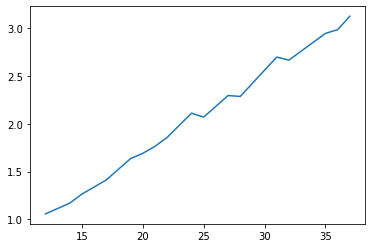

In [27]:
plt.plot(pretrub_by_iter['iterations'], pretrub_by_iter['L2 norm'])

### Accuracy per iteration

In [28]:
accuracy_t = []
for iter in pretrub_by_iter["iterations"].values:
    accuracy_t.append(1 - targeted[targeted["iterations"]<=iter].shape[0]/total_attempts)

In [29]:
iterations_t = pretrub_by_iter["iterations"].values

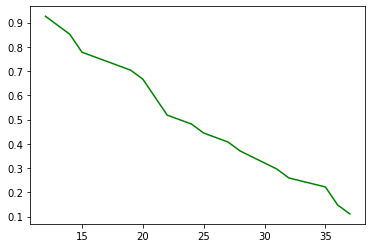

In [30]:
FGSM_t, = plt.plot(iterations_t, accuracy_t, 'g-', label='TFGSM')
#plt.plot(pretrub_by_iter["iterations"].values, accuracy)

In [31]:
FGSM_t

<ipython-input-33-27a33016a3b9>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1,n, figsize=(size, size*n))


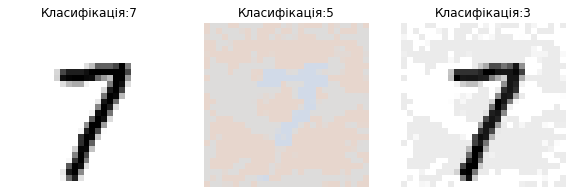

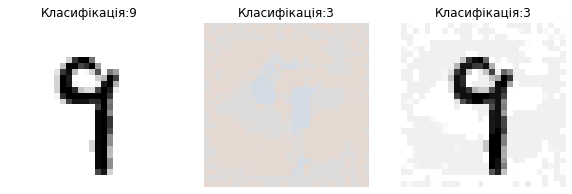

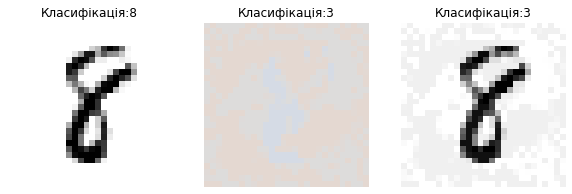

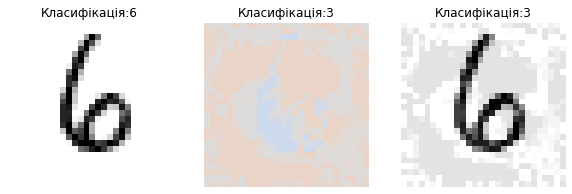

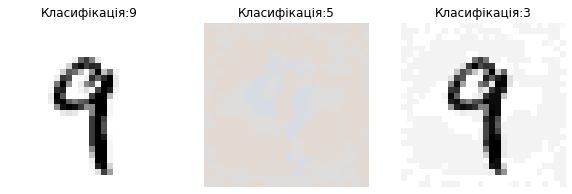

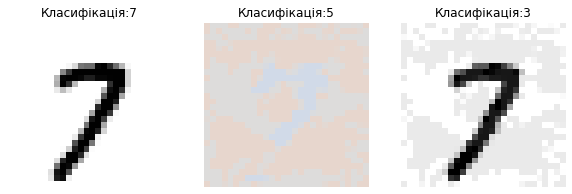

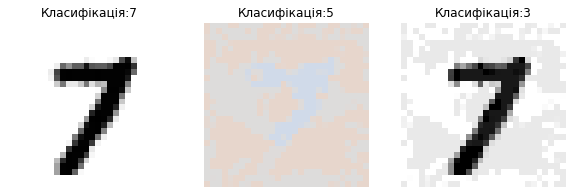

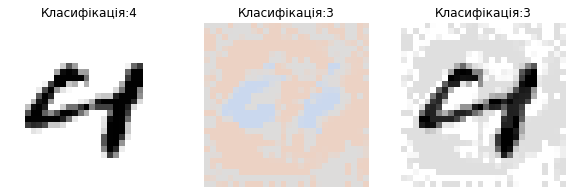

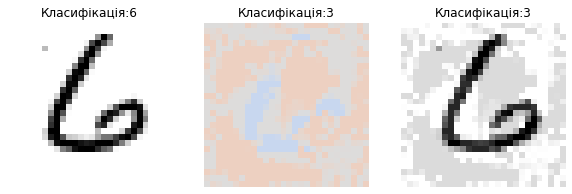

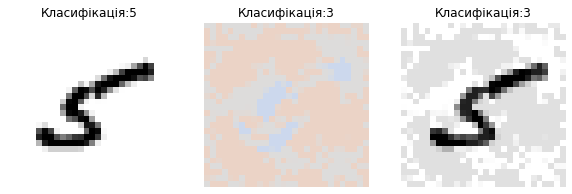

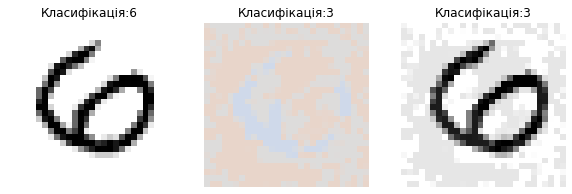

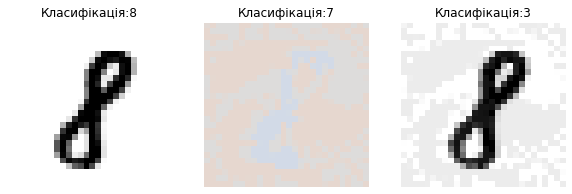

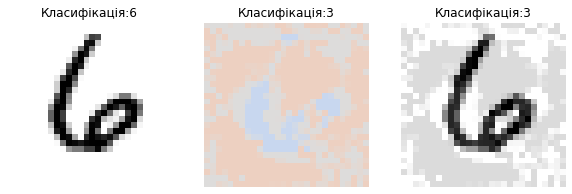

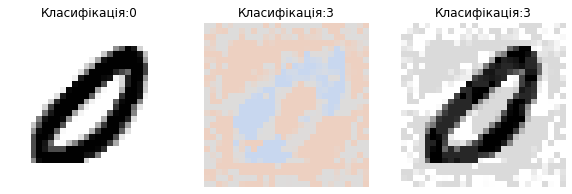

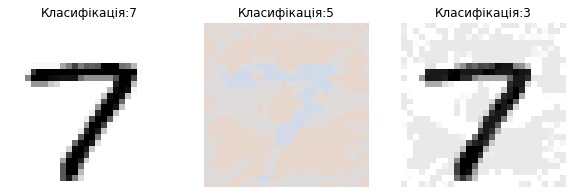

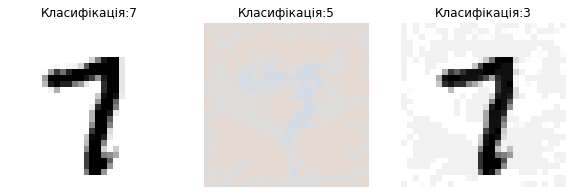

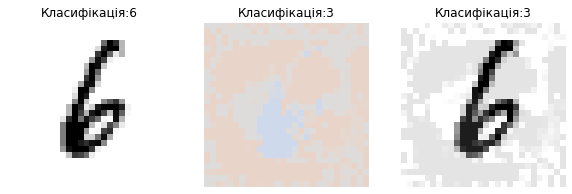

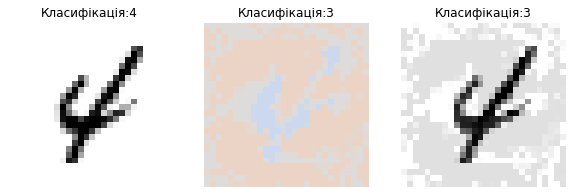

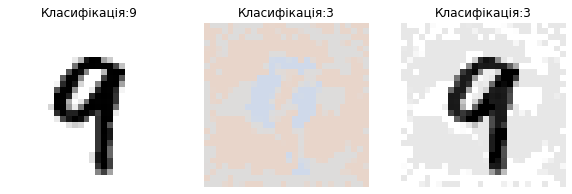

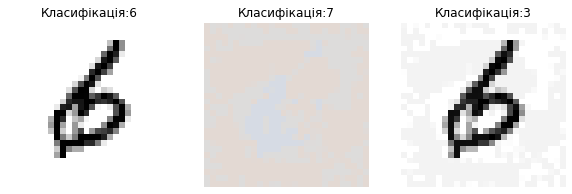

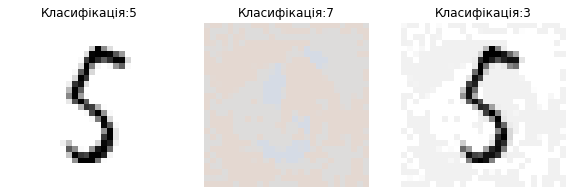

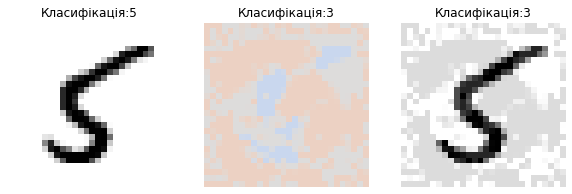

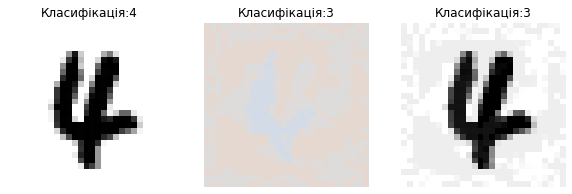

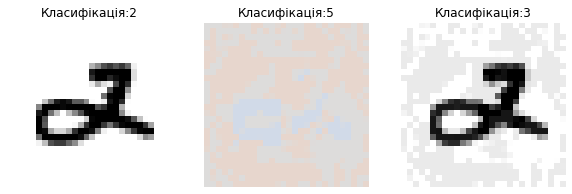

In [37]:
noise = adversarial-initial

for i in range(adversarial.shape[0]):# [0, 15, 20]:#
    show([initial[i], noise[i], (initial+noise)[i]], size=10)

## Non-Targeted attack

In [38]:
X_test_c = np.concatenate((X_test[:10], X_test[20:30])).copy()

In [39]:
len(X_test_c)

20

In [40]:
a = pd.read_csv('data/CW-300.csv')

In [41]:
a = a.drop('Unnamed: 0', axis=1)

In [42]:
CW_adv, adv_labels = a.drop('label', axis=1).to_numpy(), a['label'].values.reshape((a.shape[0], 1))

In [43]:
df = pd.DataFrame(columns = ['target','successful attempts', 'epsilon']) #'initial',
non_targeted = pd.DataFrame(columns = ['original','prediction','iterations', 'epsilon', 'L2 norm'])

X_test_c = X_test[:300].copy()#initial#np.concatenate((X_test[:10], X_test[20:30])).copy()#np.extract(cls.predict(X_test) == 3, X_test) #[10:20]
Y_test_c = Y_test[:300].copy()#true_label#np.concatenate((Y_test[:10], Y_test[20:30])).copy()#np.ones((X_test_c.shape[0], 1))*3

Y_hat_c = cls.predict(X_test_c)


tick = time.time()
for epsilon in [30/255]:#, 3/255, 5/255, 10/255, 15/255, 30/255, 50/255, 80/255, 120/255]:#[1/255]:#0.007, 0.01, 0.05, 0.1, 0.2]:
    print('epsilon =',epsilon)
    total_attempts = 0
    total_iter = 0
    example = []
    initial = []
    true_label = []
    adversarial = []
    y_hat_adv = []
    for (x, y, y_hat) in zip(X_test_c, Y_test_c, Y_hat_c):
        x = np.array([x])
        prediction = y_hat

        if(y == y_hat):

            x_adv = attack.attack(x,\
                                  np.array([[1 if i==y else 0 for i in range(10)]]),\
                                  #'ADAM',\
                                  'FGSM',\
                                  #'grads',\
                                  10000,\
                                  #pretrub_importance=0.01,\
                                  adapting_rate=epsilon, print_cost=False, targeted=False).T[0]
            
            total_iter += attack.iter

            example.append(x_adv)
            true_label.append([y])

            total_attempts += 1
            prediction = cls.predict(np.array([x_adv]))[0]
            if(prediction != y):
                initial.append(x[0])
                adversarial.append(x_adv)
                
                non_targeted = non_targeted.append({'original': y[0],'prediction': prediction,\
                                 'iterations': attack.iter, 'L2 norm': L2_norm(x[0]-x_adv),\
                                 'epsilon': epsilon}, ignore_index=True)
                
        y_hat_adv.append(prediction)
        
        if(total_attempts% 10 == 0): print(total_attempts,'instances,', len(adversarial), 'adversaries');

    example = np.array(example)
    initial = np.array(initial)
    true_label = np.array(true_label)
    adversarial = np.array(adversarial)
    y_hat_adv = np.array(y_hat_adv)

    print('------------------------------',example.shape)
    Y_hat = cls.predict(example).reshape(true_label.shape)

    #print((Y_hat == target).shape)
    #print((Y_hat != Y_test) * (Y_hat == target) * ((cls.predict(X_test)==Y_test).reshape(Y_hat.shape)))

    successful_attempts = len(adversarial)#np.sum(
    #  (Y_hat != true_label)
    #  * (Y_hat == target))
      #* (true_label == cls.predict(X_test_c).reshape(true_label.shape)))

    df = df.append({'successful attempts': successful_attempts, 'epsilon': epsilon}, ignore_index=True)

print('total time:', time.time() - tick)
print('total iter:', total_iter)
df

epsilon = 0.11764705882352941
10 instances, 10 adversaries
20 instances, 20 adversaries
30 instances, 30 adversaries
30 instances, 30 adversaries
40 instances, 40 adversaries
50 instances, 50 adversaries
60 instances, 60 adversaries
70 instances, 70 adversaries
80 instances, 80 adversaries
90 instances, 90 adversaries
100 instances, 100 adversaries
110 instances, 110 adversaries
120 instances, 120 adversaries
130 instances, 130 adversaries
140 instances, 140 adversaries
150 instances, 150 adversaries
160 instances, 160 adversaries
170 instances, 170 adversaries
180 instances, 180 adversaries
190 instances, 190 adversaries
200 instances, 200 adversaries
210 instances, 210 adversaries
220 instances, 220 adversaries
230 instances, 230 adversaries
240 instances, 240 adversaries
250 instances, 250 adversaries
260 instances, 260 adversaries
270 instances, 270 adversaries
280 instances, 280 adversaries
290 instances, 290 adversaries
------------------------------ (293, 784)
total time: 2.7662

,target,successful attempts,epsilon
0,NaN,293.0,0.117647


In [45]:
non_targeted.head()

,original,prediction,iterations,epsilon,L2 norm
0,7.0,3.0,1.0,0.117647,2.581277
1,3.0,5.0,2.0,0.117647,4.625131
2,9.0,4.0,1.0,0.117647,2.411538
3,8.0,2.0,1.0,0.117647,2.578568
4,6.0,2.0,1.0,0.117647,2.683330


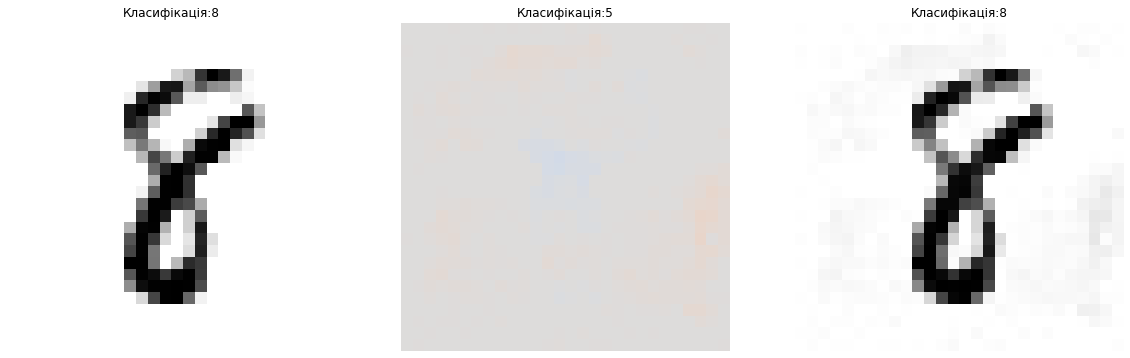

In [46]:
show([initial[3], CW_adv[3]-initial[3],CW_adv[3]], size=20)

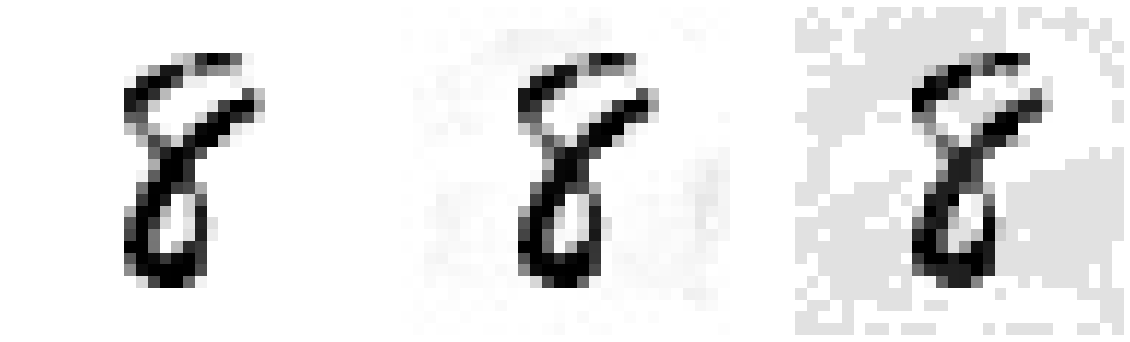

In [47]:
show_no_noise([initial[3], CW_adv[3], adversarial[3]], size=20)

In [48]:
show_no_noise(adversarial[3], size=20)

ValueError: cannot reshape array of size 1 into shape (28,28)

ValueError: Image size of 1440x1128960 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 1440x1.12896e+06 with 784 Axes>

In [ ]:
fig = show_all([CW_adv[:7],CW_adv[7:15],CW_adv[15:22]], 15,'FGSM-adv')
fig.savefig('CW-adv.pdf', bbox_inches = 'tight', pad_inches = 0)

In [ ]:
CW_non_targeted# = non_targeted

In [ ]:
non_targeted

In [ ]:
non_targeted['L2 norm'].mean()

In [ ]:
47427/75

### Accuracy by L2 norm

In [ ]:
L2_cw = L2_norm(CW_adv - X_test[:300], axis=1)[:293]
L2_cw.sort()

In [ ]:
L2_cw[:10]

In [ ]:
L2_n = non_targeted['L2 norm'].values
L2_n.sort()

In [ ]:
targeted = targeted.sort_values('iterations')


In [ ]:

targeted['L2 norm'].mean()

In [ ]:
accuracy_t = np.flip([0,  0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
L2_cw_a = []
for i in range(len(L2_cw)//10, len(L2_cw), len(L2_cw)//10):
    print(i)
    L2_cw_a.append(L2_cw[:i].mean())
    
#L2_cw.append(CW_non_targeted['L2 norm'].mean())

In [ ]:
plt.scatter(L2_cw,accuracy_cw, label='cw')

In [ ]:
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(111)


ax1.plot(L2_n_a, accuracy_t, 'o-.', label='FGSM')
ax1.plot(L2_cw_a,accuracy_t, 'o-.', label='C&W')
#ax1.plot(L2_t, accuracy_t, 'o-.', label='TFGSM')
plt.ylabel('Accuracy')
plt.xlabel('$L_2$ distance')
plt.legend()
plt.grid()
plt.savefig("CW.pdf", bbox_inches = 'tight', pad_inches = 0)
#plt.title('Accuracy score breakdown')

In [ ]:
len(men_means)

In [ ]:
labels = ['0%','10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%']
men_means = L2_cw
women_means = L2_n

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, men_means, width, label='C&W')
rects2 = ax.bar(x + width/2, women_means, width, label='FGSM')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('$L_2 distance$')
ax.set_ylabel('$L_2 distance$')

ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

'''
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)
'''
fig.tight_layout()

plt.show()
fig.savefig("CW-bar.pdf", bbox_inches = 'tight', pad_inches = 0)

### pretrub by norm

In [ ]:
non_targeted = non_targeted.sort_values("iterations")

In [ ]:
pretrub_by_iter = non_targeted.groupby('iterations', as_index=False)['L2 norm'].mean()
pretrub_by_iter = pretrub_by_iter.sort_values("iterations")

In [ ]:
plt.plot(pretrub_by_iter['iterations'], pretrub_by_iter['L2 norm'])

### Accuracy per iteration

In [ ]:
accuracy_n = []
for iter in pretrub_by_iter["iterations"].values:
    accuracy_n.append(1 - non_targeted[non_targeted["iterations"]<=iter].shape[0]/total_attempts)

In [ ]:
iterations_n = pretrub_by_iter["iterations"].values

In [ ]:
plt.plot(iterations_n, accuracy_n)

### Epsilon vs L2 norm

In [ ]:
step = 1/255
epsilon = [step, step*10, step*50, step*100, step*255]
epsilon

In [ ]:
np.sum(L2_norm(CW_adv - initial))/len(adversarial)

Для цільвої атаки стає важче знайти ошукуючий зразок при збільшенні епсилон

In [ ]:
L2_norm_ = [1.6376050113543472, 1.9951885870928328, 3.889854064462953, 7.464027117760714, 18.314954545259]
L2_norm_

In [ ]:
plt.plot(epsilon, L2_norm_)

In [ ]:
plt.figure(figsize=(10,5))
FGSM_t, = plt.plot(iterations_t, accuracy_t, 'g-', label='TFGSM')
FGSM, = plt.plot(iterations_n, accuracy_n, 'r-', label='FGSM')
plt.ylabel('Accuracy')
plt.xlabel('Iterations')
plt.legend(handles=[FGSM_t, FGSM])
plt.grid()
plt.savefig("FGSM-accuracy.pdf", bbox_inches = 'tight', pad_inches = 0)
#plt.title('Accuracy score breakdown')

### Epsilon vs iterations

In [ ]:
non_targeted.head()

In [ ]:
eps_iter = non_targeted.groupby('epsilon', as_index=False)['iterations'].mean()
eps_iter

In [ ]:
plt.figure(figsize=(10,5))
EI, = plt.plot(eps_iter['iterations'], eps_iter['epsilon'], '.-')
plt.ylabel('Epsilon')
plt.xlabel('Iterations')
plt.legend(handles=[EI])
plt.grid()
plt.savefig("epsilon-iter.pdf", bbox_inches = 'tight', pad_inches = 0)
#plt.title('Accuracy score breakdown')

In [ ]:
total_attempts

In [ ]:
accuracy_score(Y_test_c, y_hat_adv)

In [ ]:
np.sum(df['successful attempts'].values) / total_attempts

In [ ]:
#print(cls.predict(example))

noise = adversarial-initial

for i in range(10):#adversarial.shape[0]):# [3,5,6,10,13,14]:#
    show([initial[i], noise[i], (initial+noise)[i]], size=7)
    
plt.savefig("zoo.pdf", bbox_inches = 'tight', pad_inches = 0)

In [ ]:
show([instance[0], instance[0]-X_test[5:6][0]])

In [ ]:
FGSM_noise = noise

In [ ]:
np.sum(L2_norm(FGSM_noise))

In [ ]:
ADAM_noise = noise

In [ ]:
np.sum(L2_norm(ADAM_noise))

In [ ]:
L2_noise = noise

In [ ]:
np.sum(L2_norm(L2_noise))

In [ ]:
fig, = plt.figure(figsize=(10,5))
gm, = plt.plot(attack.epsilons, non_targeted_scores, 'g*', label='gradient method')
gsm, = plt.plot(attack.epsilons, attack.scores, 'r*', label='gradient sign method')
plt.ylabel('accuracy_score')
plt.xlabel('eta')
plt.legend(handles=[gm, gsm])
plt.title('Accuracy score breakdown')

In [ ]:
cls.predict(adversarial)

In [ ]:
np.sum(initial>1)

In [ ]:
np.zeros((X_test.shape[0], 10))+[1 if i == 1 else 0 for i in range(10)]

In [ ]:
df[df.target == 1]

In [ ]:
cls.predict(example.T).shape

### Iterative attack

In [ ]:
instance = X_test[7:10].copy()
Y_test[7:10]

In [ ]:
cls.predict(instance)

In [ ]:
target = np.array([[0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [ ]:
example = attack.attack(instance, target, 2000, adapting_rate=0.01)

In [33]:
def show(examples, size=3):
    n = len(examples)
    fig, ax = plt.subplots(1,n, figsize=(size, size*n))
    for (i, e) in enumerate(examples):
        ax[i].set_title('Класифікація:'+str(cls.predict(e.reshape((1,784)))[0]))
        ax[i].imshow(e.reshape((28,28)), cmap=('coolwarm' if i%3==1 else 'gray_r'),
                     vmin=(-1 if i%3==1 else 0), vmax=1) #*255 % 255
        ax[i].axis('off')

In [34]:
def show_no_noise(examples, size=3):
    n = len(examples)
    fig, ax = plt.subplots(1,n, figsize=(size, size*n))
    for (i, e) in enumerate(examples):
        #ax[i].set_title('Класифікація:'+str(cls.predict(e.reshape((1,784)))[0]))
        ax[i].imshow(e.reshape((28,28)), cmap='gray_r'
                     ) #*255 % 255
        ax[i].axis('off')

In [35]:
def show_all(examples, size =15, name='adversarial'):
    n = len(examples)
    fig, ax = plt.subplots(3,7, figsize=(size, 6))
    for i in range(3):
      for j in range(7):
        
        ax[i][j].set_title('Класифікація:'+str(cls.predict(examples[i][j].reshape((1,784)))[0]))
        ax[i][j].imshow(examples[i][j].reshape((28,28)), cmap='gray_r') #*255 % 255
        ax[i][j].axis('off')
        
    return fig

In [36]:
def show_all_lab(examples, labels, size =15, name='adversarial'):
    n = len(examples)
    fig, ax = plt.subplots(3,7, figsize=(size, 6))
    for i in range(3):
      for j in range(7):
        
        ax[i][j].set_title('Класифікація:'+str(labels[i][j][0]))
        ax[i][j].imshow(examples[i][j].reshape((28,28)), cmap='gray_r') #*255 % 255
        ax[i][j].axis('off')
        
    return fig

In [ ]:
fig = show_all_lab([CW_adv[:7],CW_adv[7:15],CW_adv[15:22]], [adv_labels[:7],adv_labels[7:15],adv_labels[15:22]])

In [ ]:
fig.savefig("CW-adv.pdf", bbox_inches = 'tight', pad_inches = 0)

In [ ]:
[adversarial[:7],adversarial[7:15],adversarial[15:22]]

In [ ]:
show_all([adversarial[:7],adversarial[7:15],adversarial[15:22]])

In [ ]:
for i in range(example.shape[1]):
    show([example.T[i], instance[i], (example.T-instance)[i]])
    

In [ ]:
L2_norm(example.T - instance, axis=1)

In [ ]:
L2_norm(example_L2.T - instance, axis=1)

In [ ]:
np.sum(example.T != instance)

In [ ]:
cls.predict(example.T)

In [ ]:
cls.predict(instance)

In [ ]:
example_L2 = example